#### 导入需要的库和相关模块

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import FashionMNIST

## 6.3.1 图像数据准备

In [2]:
# 使用FashionMNIST数据，准备训练数据集
train_data = FashionMNIST(
    root=".data/FashionMNIST",  # 数据的路径
    train=True, # 只使用训练数据集
    transform=transforms.ToTensor(), 
    download=False
)
# 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset=train_data, # 使用的数据集
    batch_size=64, # 批处理样本大小
    shuffle=False, # 每次迭代前不打乱数据
    num_workers=2 # 使用两个进程
)
# 计算train_loader有多少个batch
print("train_loader的batch数量为：", len(train_loader))

train_loader的batch数量为： 938


#### 获得一个batch的数据，将其可视化

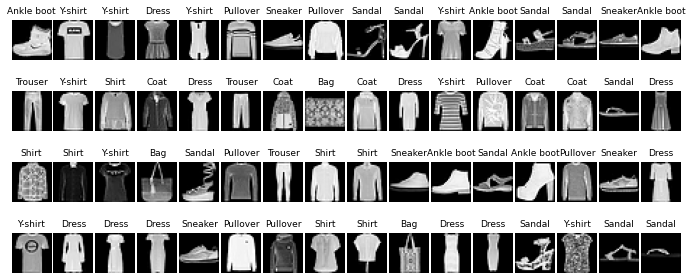

In [3]:
for step, (b_x, b_y) in enumerate(train_loader):
    if step > 0:
        break
    # 可视化一个batch的图像
    batch_x = b_x.squeeze().numpy()
    batch_y = b_y.numpy()
    class_label = train_data.classes
    class_label[0] = "Y-shirt"
    plt.figure(figsize=(12,5))
    for ii in np.arange(len(batch_y)):
        plt.subplot(4,16,ii+1)
        plt.imshow(batch_x[ii,:,:], cmap=plt.cm.gray)
        plt.title(class_label[batch_y[ii]], size=9)
        plt.axis("off")
        plt.subplots_adjust(wspace=0.05)

#### 导入测试数据集后，将所有样本处理为一个整体，看作一个batch用于测试

In [4]:
test_data = FashionMNIST(
    root="./data/FashionMNIST", #数据的路径
    train=False, # 不使用训练数据集
    download=False
)
# 为数据添加一个通道维度，并且取值范围缩放到0~1之间
test_data_x = test_data.data.type(torch.FloatTensor) / 255.0
test_data_x = torch.unsqueeze(test_data_x, dim=1)
test_data_y = test_data.targets # 测试集的标签
print("test_data_x.shape: ", test_data_x.shape)
print("test_data_y.shape: ", test_data_y.shape)

test_data_x.shape:  torch.Size([10000, 1, 28, 28])
test_data_y.shape:  torch.Size([10000])


## 6.3.2 卷积神经网络的搭建

In [5]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        # 定义第一个卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, # 输入的feature map
                out_channels=16, # 输出的feature map
                kernel_size=3, # 卷积核尺寸
                stride=1, # 卷积核步长
                padding=1 # 进行填充
            ), # 卷积后：(1*28*28) -> (16*28*28)
            nn.ReLU(), # 激活函数
            nn.AvgPool2d(
                kernel_size=2, # 平均值池化层，使用2*2
                stride=2, # 池化步长为2
            ), # 池化后：(16*28*28) -> (16*14*14)
        )
        # 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,3,1,0), # 卷积操作(16*14*14) -> (32*12*12)
            nn.ReLU(), # 激活函数
            nn.AvgPool2d(2,2) # 最大值池化操作 (32*12*12) -> (32*6*6)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*6*6,256), 
            nn.ReLU(), 
            nn.Linear(256,128), 
            nn.ReLU(), 
            nn.Linear(128,10)
        )
    
    # 定义网络的前向传播路径
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # 展平多维的卷积图层
        output = self.classifier(x)
        return output

&emsp;&emsp;上面程序中的类MyConvNet()通过nn.Sequential(),nn.Conv2d(),nn.ReLU(),nn.AvgPool2d(),nn.Linear()等层，定义了一个拥有两个卷积层和三个全连接层的卷积神将网络分类器，
并且在forward()函数中定义了数据在网络中的前向传播过程，然后使用myconvnet=MyConvNet()得到可用于学习的网络myconvnet，网络结构输出如下：

#### 输出网络结构

In [6]:
myConvnet = MyConvNet()
print(myConvnet)

MyConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


## 6.3.3 卷积神经网络训练与预测

定义train_model()函数，用训练数据集来训练myconvnet

#### 定义网络的训练过程函数

| 元素 | 名称 |
| :----:| :----: |
| model | 网络模型 |
| traindataloader | 训练数据集，会切分为训练集和验证集 |
| train_rate | 训练集 |
| batchsize | 百分比 |
| criterion | 损失函数 |
| optimizer | 优化方法 |

In [7]:
def train_model(model, traindataloader, train_rate, criterion, optimizer, num_epochs=25):
    # 计算训练使用的batch数量
    batch_num = len(traindataloader)
    train_batch_num = round(batch_num * train_rate)
    # 复制模型的参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print("Epoch{}/{}".format(epoch, num_epochs-1))
        print("-" * 10)
        # 每个epoch有两个训练阶段
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        for step,(b_x, b_y) in enumerate(traindataloader):
            if step < train_batch_num:
                model.train() # 设置模式为训练模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * b_x.size(0)
                train_corrects += torch.sum(pre_lab == b_y.data)
                train_num += b_x.size(0)
            else:
                model.eval() # 设置模式为评估模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)
                val_loss += loss.item() * b_x.size(0)
                val_corrects += torch.sum(pre_lab == b_y.data)
                val_num += b_x.size(0)
        # 计算一个epoch在训练集和验证集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item() / train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item() / val_num)
        print("{}Train Loss: {:.4f} Train Acc: {:.4f}".format(epoch, train_loss_all[-1], train_acc_all[-1]))
        print("{}Val Loss: {:.4f} Val Acc: {:.4f}".format(epoch, val_loss_all[-1], val_acc_all[-1]))

        # 拷贝模型最高精度下的参数
        if val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            time_use = time.time() - since
            print("Train and val complete in {:.0f}分{:.0f}秒".format(time_use // 60, time_use % 60))

    # 使用最好模型的参数
    model.load_state_dict(best_model_wts)
    train_process = pd.DataFrame(
        data={"epoch":range(num_epochs),
              "train_loss_all":train_loss_all, 
              "val_loss_all":val_loss_all,
              "train_acc_all":train_acc_all,
              "val_acc_all":val_acc_all
        }
    )
    return model, train_process

上面的train_model()函数通过train_batch_num确定用于训练发batch的数量，  
并且在每轮迭代中，如果step<train_batch_num，则进入训练模式，否则进入验证模式。  
在模型的训练和验证过程中，分别输出当前损失函数的大小和对应的识别精度，并将它们保存在列表汇总中，最后组成数据表格train_process输出。  
为了保存模型最高精度下的训练参数，使用copy.deepcopy()函数将模型最优的参数保存在best_model_wts中，最终将所有的训练结果使用model.load_state_dict(best_model_wts)将最优的参数赋值给最终的模型

#### 对模型进行训练

myConvnet分类器使用了Adam分类器，损失函数为交叉熵函数。train_model()将训练集train_loader的80%用于训练，20%用于测试，共训练25轮：

In [8]:
optimizer = torch.optim.Adam(myConvnet.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss() # 损失函数
myConvnet, train_process = train_model(
    model=myConvnet, traindataloader=train_loader, train_rate=0.8, criterion=criterion, 
    optimizer=optimizer, num_epochs=25
)

Epoch0/24
----------
0Train Loss: 0.7307 Train Acc: 0.7334
0Val Loss: 0.5212 Val Acc: 0.8042
Train and val complete in 0分18秒
Epoch1/24
----------
1Train Loss: 0.4761 Train Acc: 0.8241
1Val Loss: 0.4452 Val Acc: 0.8372
Train and val complete in 0分35秒
Epoch2/24
----------
2Train Loss: 0.4150 Train Acc: 0.8484
2Val Loss: 0.4063 Val Acc: 0.8508
Train and val complete in 0分52秒
Epoch3/24
----------
3Train Loss: 0.3777 Train Acc: 0.8617
3Val Loss: 0.3781 Val Acc: 0.8612
Train and val complete in 1分9秒
Epoch4/24
----------
4Train Loss: 0.3518 Train Acc: 0.8708
4Val Loss: 0.3576 Val Acc: 0.8684
Train and val complete in 1分26秒
Epoch5/24
----------
5Train Loss: 0.3318 Train Acc: 0.8784
5Val Loss: 0.3429 Val Acc: 0.8737
Train and val complete in 1分43秒
Epoch6/24
----------
6Train Loss: 0.3151 Train Acc: 0.8836
6Val Loss: 0.3310 Val Acc: 0.8786
Train and val complete in 2分0秒
Epoch7/24
----------
7Train Loss: 0.3008 Train Acc: 0.8888
7Val Loss: 0.3206 Val Acc: 0.8828
Train and val complete in 2分17秒
Ep

#### 可视化上述节卷积神经网络，并保存到文件夹

In [9]:
import hiddenlayer as hl
# 可视化卷积神经网络
hl_graph = hl.build_graph(myConvnet, torch.zeros([1,1,28,28]))
hl_graph.theme = hl.graph.THEMES["blue"].copy()
# 将可视化网络保存为图片
hl_graph.save("myConvnet_hl.png", format="png")

#### 用PyTorchViz库可视化网络

In [10]:
from torchviz import make_dot
# 使用make_dot可视化网络
x = torch.randn(1,1,28,28).requires_grad_(True)
y = myConvnet(x)
MyConvnetviz = make_dot(y, params=dict(list(myConvnet.named_parameters()) + [('x', x)]))
# 将MyConvnetviz保存为图片
MyConvnetviz.format = "png"
# 指定文件保存位置
MyConvnetviz.directory = "MyConvnet_viz02"
MyConvnetviz.view() # 会自动在当前文件夹生成文件

'MyConvnet_viz02\\Digraph.gv.png'

#### 可视化模型训练过程

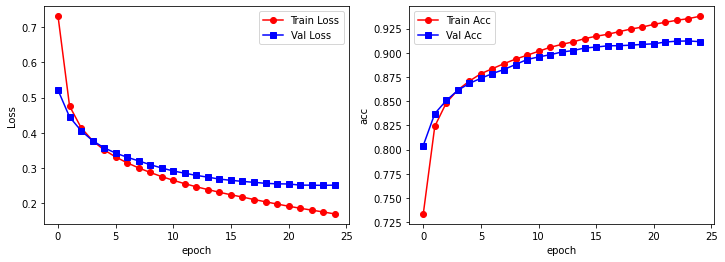

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_process.epoch, train_process.train_loss_all, 
         "ro-", label="Train Loss")
plt.plot(train_process.epoch, train_process.val_loss_all, 
         "bs-", label="Val Loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(train_process.epoch, train_process.train_acc_all, 
         "ro-", label="Train Acc")
plt.plot(train_process.epoch, train_process.val_acc_all, 
         "bs-", label="Val Acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

#### 对测试集进行预测，并可视化预测效果

In [12]:
myConvnet.eval()
output = myConvnet(test_data_x)
pre_lab = torch.argmax(output, 1)
acc = accuracy_score(test_data_y, pre_lab)
print("在测试集上的预测精度为: ", acc)

在测试集上的预测精度为:  0.9086


#### 计算混淆矩阵并可视化

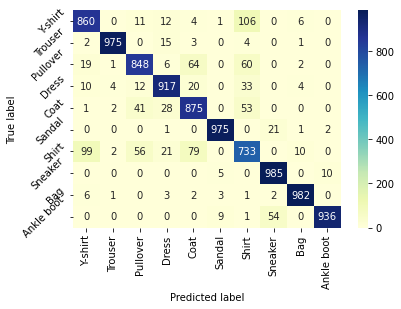

In [13]:
conf_mat = confusion_matrix(test_data_y, pre_lab)
df_cm = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.yaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

## 6.3.4 空洞卷积神经网络的搭建

In [15]:
class MyConvdilaNet(nn.Module):
    def __init__(self):
        super(MyConvdilaNet, self).__init__()
        ## 定义第一个卷积层
        self.conv1 = nn.Sequential(
            ## 卷积后：(1x28x28) -> (16x26x26)
            nn.Conv2d(1,16,3,1,1,dilation=2), 
            nn.ReLU(),   ## 激活函数
            nn.AvgPool2d(2,2)  ##(16*26*26) -> (16*13*13)
        )
        ## 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,3,1,0,dilation=2), 
            ## 卷积操作：(16x13x13) -> (39x9x9)
            nn.ReLU(),   ## 激活函数
            nn.AvgPool2d(2,2) ## 最大值池化操作：(32*9*9) -> (32*4*4)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*4*4, 256), 
            nn.ReLU(), 
            nn.Linear(256, 128), 
            nn.ReLU(), 
            nn.Linear(128, 10)
        )

    ## 定义网络的向前传播路径
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) ## 展平多维的卷积图层
        output = self.classifier(x)
        return output

## 输出网络结构
myconvdilanet = MyConvdilaNet()

## 6.3.5 空洞卷积神经网络训练与预测

In [16]:
## 对模型进行训练
optimizer = torch.optim.Adam(myconvdilanet.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()  ## 损失函数
myconvdilanet, train_process = train_model(
    myconvdilanet, train_loader, 0.8, 
    criterion, optimizer, num_epochs=25)

Epoch0/24
----------
0Train Loss: 0.9051 Train Acc: 0.6657
0Val Loss: 0.6454 Val Acc: 0.7468
Train and val complete in 0分12秒
Epoch1/24
----------
1Train Loss: 0.6129 Train Acc: 0.7634
1Val Loss: 0.5665 Val Acc: 0.7844
Train and val complete in 0分24秒
Epoch2/24
----------
2Train Loss: 0.5432 Train Acc: 0.7931
2Val Loss: 0.5143 Val Acc: 0.8098
Train and val complete in 0分36秒
Epoch3/24
----------
3Train Loss: 0.4975 Train Acc: 0.8150
3Val Loss: 0.4782 Val Acc: 0.8237
Train and val complete in 0分48秒
Epoch4/24
----------
4Train Loss: 0.4634 Train Acc: 0.8297
4Val Loss: 0.4520 Val Acc: 0.8338
Train and val complete in 1分1秒
Epoch5/24
----------
5Train Loss: 0.4364 Train Acc: 0.8397
5Val Loss: 0.4288 Val Acc: 0.8433
Train and val complete in 1分13秒
Epoch6/24
----------
6Train Loss: 0.4130 Train Acc: 0.8484
6Val Loss: 0.4070 Val Acc: 0.8532
Train and val complete in 1分25秒
Epoch7/24
----------
7Train Loss: 0.3925 Train Acc: 0.8563
7Val Loss: 0.3896 Val Acc: 0.8590
Train and val complete in 1分37秒
E

#### 使用折线图将模型训练过程中的精度和损失函数进行可视化，程序代码如下：

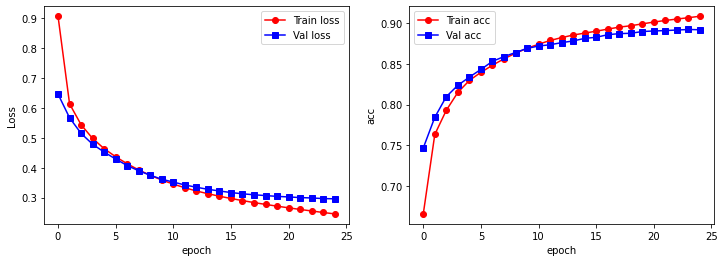

In [18]:
## 可视化模型训练过程中的精度和损失函数
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_process.epoch, train_process.train_loss_all, 
        "ro-", label="Train loss")
plt.plot(train_process.epoch, train_process.val_loss_all, 
        "bs-", label="Val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(train_process.epoch, train_process.train_acc_all, 
        "ro-", label="Train acc")
plt.plot(train_process.epoch, train_process.val_acc_all, 
        "bs-", label="Val acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

#### 下面使用输出的模型在测试集上进行预测，以计算模型的泛化能力，可使用如下所示的程序：

In [19]:
## 对测试集进行预测，并可视化预测效果
myconvdilanet.eval()
output = myconvdilanet(test_data_x)
pre_lab = torch.argmax(output, 1)
acc = accuracy_score(test_data_y, pre_lab)
print("在测试集上的预测精度为：", acc)

在测试集上的预测精度为： 0.8889


#### 使用混淆矩阵表示，并将其可视化，观察在每类数据上的预测情况

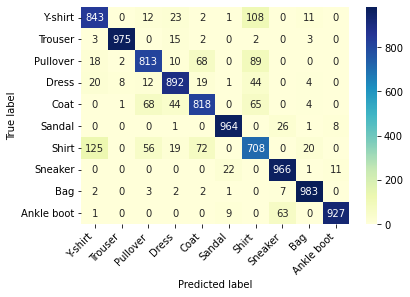

In [21]:
## 计算混淆矩阵并可视化
conf_mat = confusion_matrix(test_data_y, pre_lab)
df_cm = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()